In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

In [3]:
#Get raw accelerometer data
path = 'WISDM_ar_v1.1_raw.txt'
#Read in the file, specifying the headers
df = pd.read_csv(path,header=None,names=['user-id','activity','timestamp','x-axis','y-axis','z-axis'])
#Every row in z-axis column ends with a semicolon, need to remove this with regex
df['z-axis'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
#Take an initial look at the data
df.head()
#We have user-specific user-id's, the activity we want to predict, a time which will be our x-axis graphically
#Then we have the 3 accelerometer axes, 'x-axis' is just the direction but won't actually be used as any x-axis

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [4]:
#Make a function to plot the action
def plt_act(activity, df, rows=len(df),y_label='Acceleration (m/s$^2$)',x_label='Time (min)'):
    #A reading of 10 corresponds to 1g, so we multiply by 9.8/10 to convert to m/s^2
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:rows]*9.8/10
    #Reset index so it can be used for conversion
    data = data.reset_index()
    #the data is currently by row, each sample was taken at 50ms, divided by 60000 to get min
    data['index']=(data['index']-min(data['index']))*50/60000
    #Set the index back into place after conversion
    data = data.set_index('index')
    #Set figure size and title as activity
    axis = data.plot(subplots=True, figsize=(16, 12),title=activity)
    #Set x label
    plt.xlabel(x_label)
    for ax in axis:
        #Set the x,y,z labels in legend and set the y axis label
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        ax.set_ylabel(y_label)

In [5]:
count_nan = len(df) - df.count()
#Are there any na's?
print(count_nan)
#Remove those
df.dropna(axis=0, how='any', inplace=True)
count_nan = len(df) - df.count()
#Verify all are gone
print(count_nan)

user-id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       1
dtype: int64
user-id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       0
dtype: int64


In [6]:
#Use this to get an idea of what users did what actions and how many data points they did it for
#Not every user did every action, some did the same action many times
df[['user-id','activity','x-axis','y-axis','z-axis']].groupby(['user-id','activity']).count().head(20)

x-axis  y-axis  z-axis
user-id activity                          
1       Downstairs    2941    2941    2941
        Jogging      11056   11056   11056
        Upstairs      3120    3120    3120
        Walking      12861   12861   12861
2       Jogging      11786   11786   11786
        Walking      11739   11739   11739
3       Downstairs    3326    3326    3326
        Jogging      11018   11018   11018
        Sitting       1609    1609    1609
        Standing      2824    2824    2824
        Upstairs      3411    3411    3411
        Walking      12973   12973   12973
4       Downstairs    1763    1763    1763
        Jogging        895     895     895
        Sitting       1257    1257    1257
        Upstairs      1377    1377    1377
        Walking       6079    6079    6079
5       Downstairs    3281    3281    3281
        Jogging       6405    6405    6405
        Sitting       1664    1664    1664

In [7]:
#Let's get how many data points we have per action
count_d = {}
for activity in df['activity'].unique():
    count = df[df['activity']==activity].shape[0]
    count_d.update({activity:count})
print(count_d)

{'Jogging': 342176, 'Walking': 424397, 'Upstairs': 122869, 'Downstairs': 100427, 'Sitting': 59939, 'Standing': 48395}


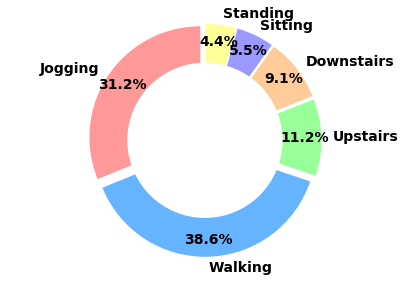

In [8]:
#Let's use that dictionary to make a donut chart
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

labels = count_d.keys()
sizes = count_d.values()
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#9999ff','#ffff99']
#Make the actions pop out of the donut a bit, radially
explode = (0.05,0.05,0.05,0.05,0.05,0.05)
 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85,explode=explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

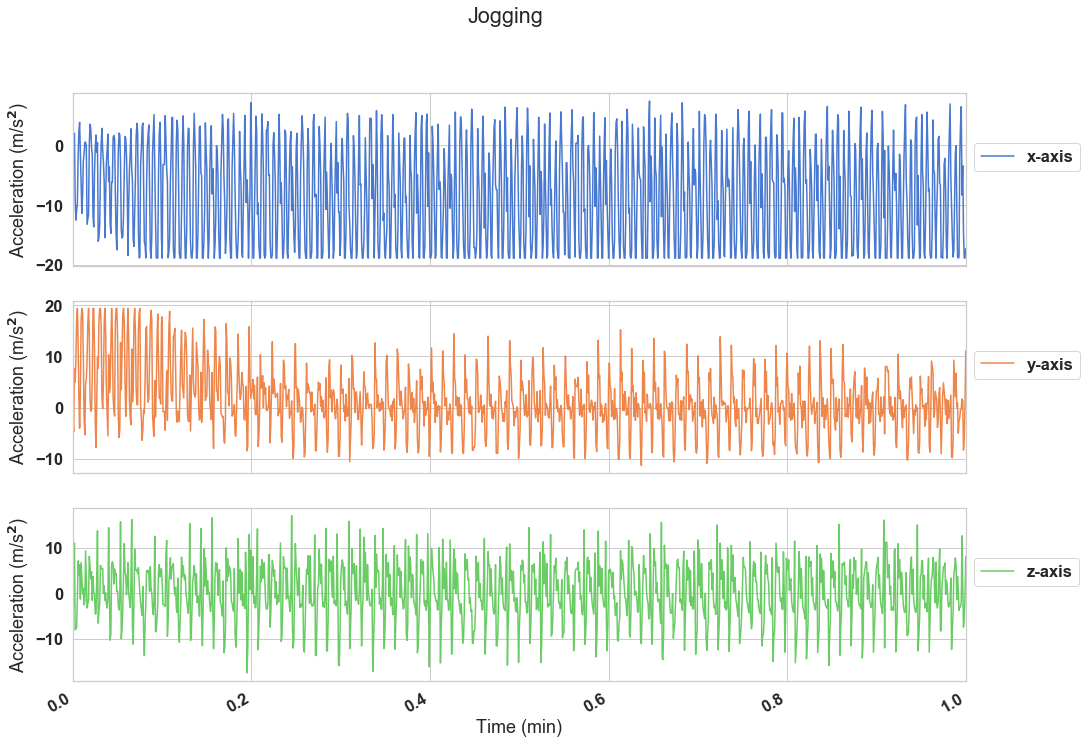

In [9]:
#Show the accelerometer data
from pylab import rcParams
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
def conflt(data):
    return np.float(data)
#Need to set z-axis back to float after regexing out ';' made it an object
df['z-axis'] = df['z-axis'].apply(conflt)
plt_act("Jogging",df[df['user-id']==3],1201)

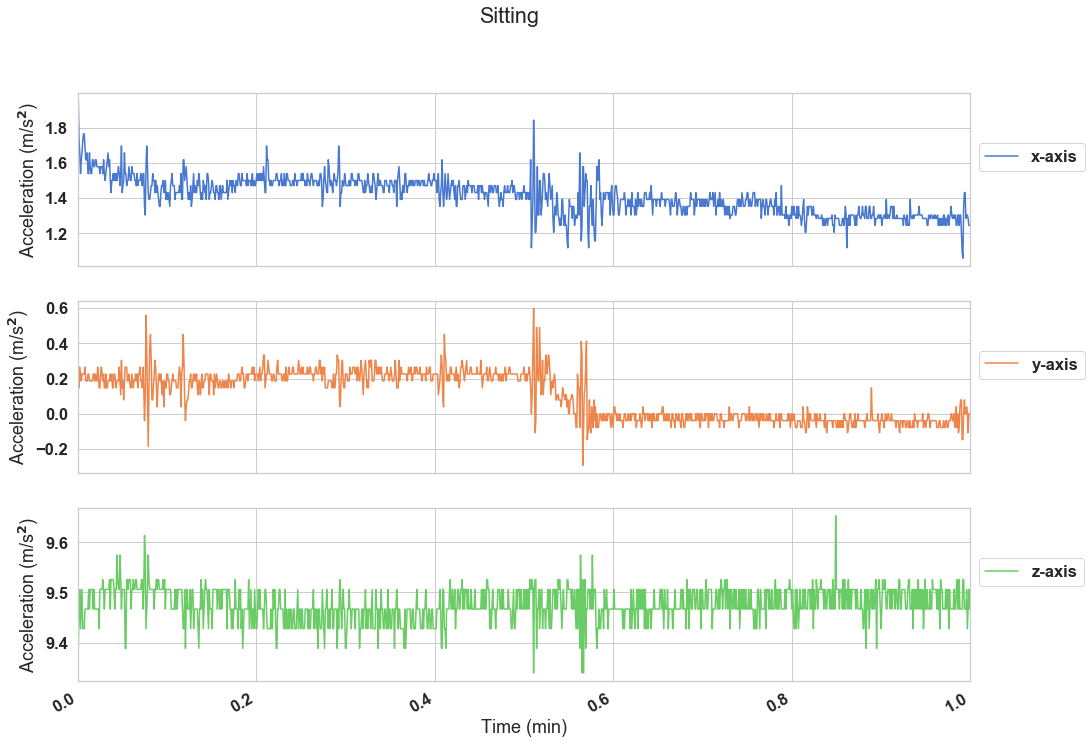

In [10]:
plt_act("Sitting",df[df['user-id']==3],1201)

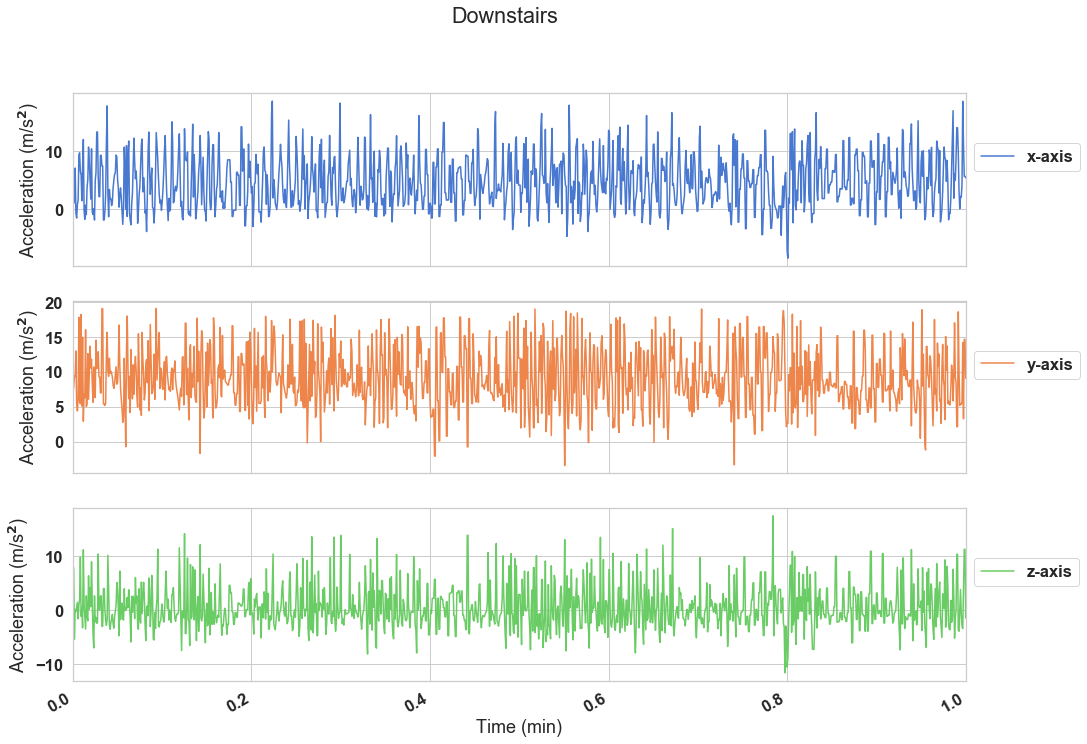

In [11]:
plt_act("Downstairs", df[df['user-id']==16],1201)

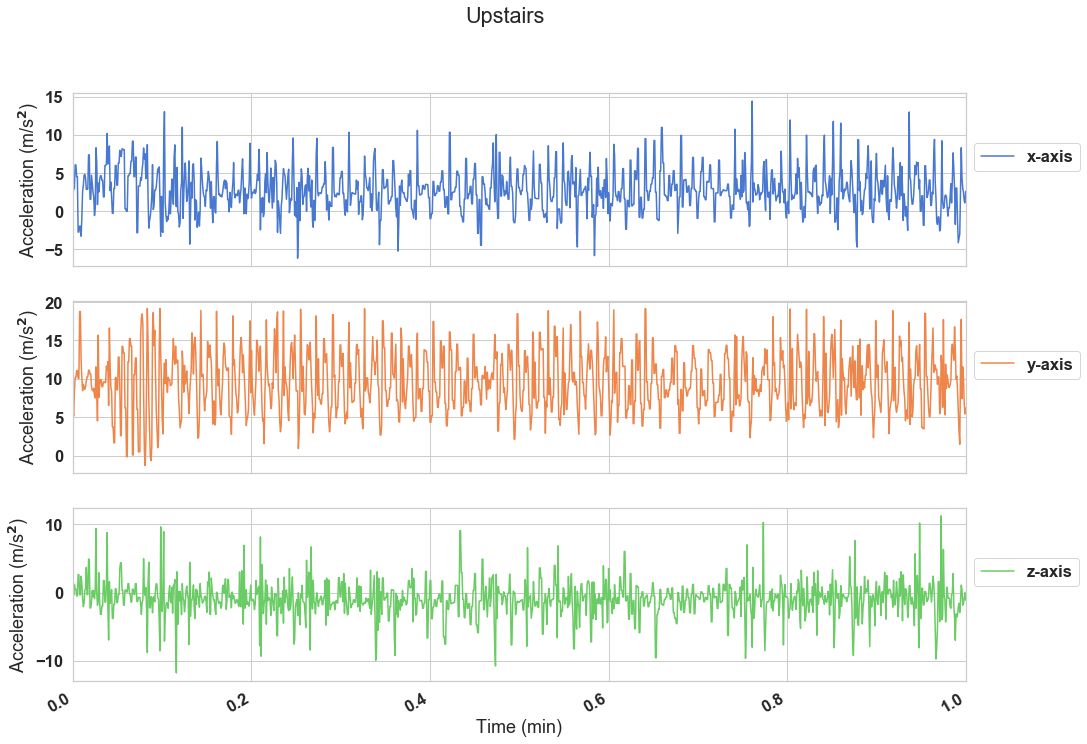

In [12]:
plt_act("Upstairs",df[df['user-id']==16],1201)

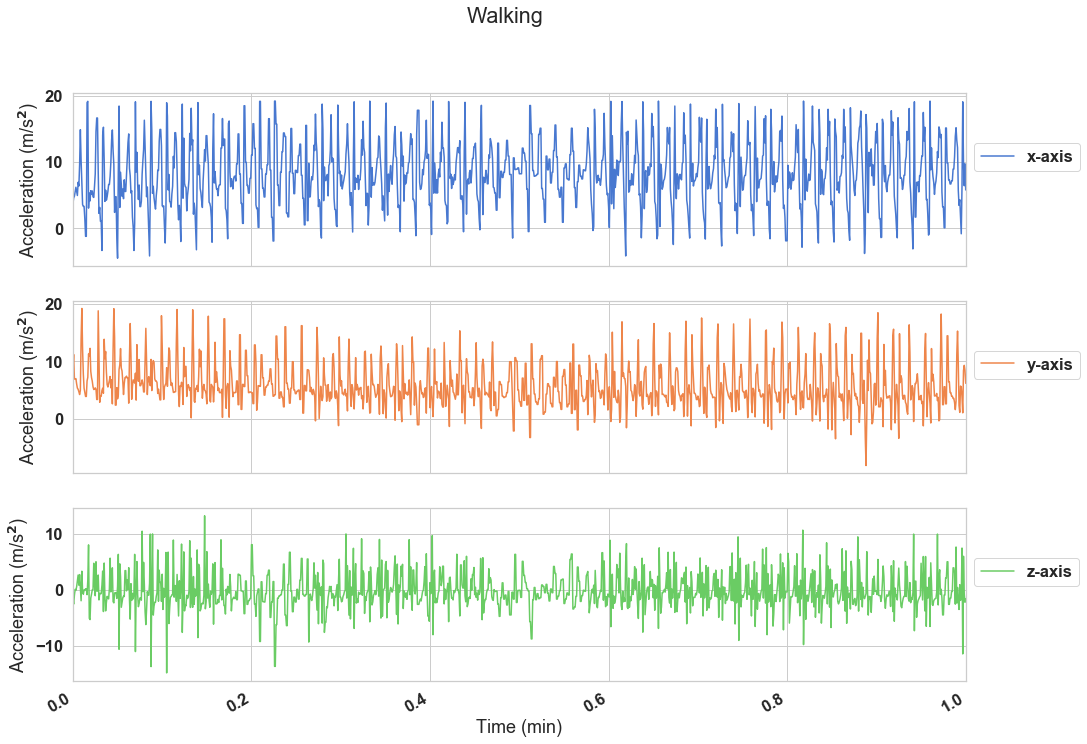

In [13]:
plt_act("Walking", df[df['user-id']==16],1201)

In [14]:
#Create a function to break up the accelerometer data into time steps and a way that can be reshaped by the model
#This code would not have been possible without Ackerman, 2018 citation in paper
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    #Step by time_Step input over the values
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        #Put the three axes togehter
        segments.append([xs, ys, zs])
        #Append the label
        labels.append(label)

    #Put those segments together
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [15]:
LABEL = "ActivityEncoded"
# Prepare to encode by instantiating object
le = preprocessing.LabelEncoder()
#Change all our string labels into unique integers via encoding
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [16]:
#Take a look at the data, ensure it was encoded up til the end
df[df.activity=='Sitting'].tail(5)

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
1098199,19,Sitting,131623331483000,9.00,-1.57,1.69,2
1098200,19,Sitting,131623371431000,9.04,-1.46,1.73,2
1098201,19,Sitting,131623411592000,9.08,-1.38,1.69,2
1098202,19,Sitting,131623491487000,9.00,-1.46,1.73,2
1098203,19,Sitting,131623531465000,8.88,-1.33,1.61,2


In [17]:
#Prepare the mapping of this encoding
#This will simplify translating action strings in visualizations later
mapping = dict(zip(le.classes_, range(len(le.classes_))))
mapping

{'Downstairs': 0,
 'Jogging': 1,
 'Sitting': 2,
 'Standing': 3,
 'Upstairs': 4,
 'Walking': 5}

In [18]:
#This function allows us to use up until a certain user-id for training
def get_cutoff(df,percent_train):
    ids = sorted(df['user-id'].unique())
    newList = ids[int(len(ids) * (1-percent_train/100)):]
    return min(newList)
#Pick which time periods will be best for the normal amount of time users performed actions (50Hz readings)
TIME_PERIODS = 80
STEP_DISTANCE = 40
PERCENT_TRAIN = 25
#Get the min user to train up until, inclusive
min_user = get_cutoff(df,PERCENT_TRAIN)
df_test = df[df['user-id'] > min_user]
df_train = df[df['user-id'] <= min_user]
#Make training data in segmented form from this subset of users
x_train, y_train = create_segments_and_labels(df_train,TIME_PERIODS,STEP_DISTANCE,LABEL)

In [19]:
#240 is the number of time periods over the number of features (or axes)
N_FEATURES = 3
input_shape = (TIME_PERIODS*N_FEATURES)
#We reshape each train into a manageble way for the model to ingest from this
x_train = x_train.reshape(x_train.shape[0], input_shape)
#We reshape y for the number of actions that exist
y_train = np_utils.to_categorical(y_train, len(mapping))
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 240)
y_train shape:  (20868, 6)


In [24]:
#We build a sequential model after reshaping the input, below is CNN for now with two pooling layers + dropout
from keras.layers import LSTM
#import os
#os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, N_FEATURES), input_shape=(input_shape,)))
#model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, N_FEATURES)))
#model_m.add(Conv1D(100, 10, activation='relu'))
#model_m.add(Conv1D(2000, 10, activation='relu'))
#model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(LSTM(300, return_sequences=True,activation='relu'))
model_m.add(MaxPooling1D(2))
model_m.add(LSTM(300, return_sequences=True,activation='relu'))
model_m.add(GlobalAveragePooling1D())
#model_m.add(Dropout(0.5))
model_m.add(Dense(len(mapping), activation='softmax'))
print(model_m.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 80, 300)           364800    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 40, 300)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 40, 300)           721200    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1806      
Total params: 1,087,806
Trainable params: 1,087,806
Non-trainable params: 0
____________________________________________

Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 207s 12ms/step - loss: 0.9758 - accuracy: 0.6396 - val_loss: 0.7609 - val_accuracy: 0.7724
Epoch 2/50
16694/16694 [==============================] - 194s 12ms/step - loss: 0.5802 - accuracy: 0.7867 - val_loss: 0.6720 - val_accuracy: 0.7772
Epoch 3/50
16694/16694 [==============================] - 190s 11ms/step - loss: 0.4669 - accuracy: 0.8200 - val_loss: 0.5693 - val_accuracy: 0.7942
Epoch 4/50
16694/16694 [==============================] - 187s 11ms/step - loss: 0.5088 - accuracy: 0.8151 - val_loss: 0.6565 - val_accuracy: 0.7765


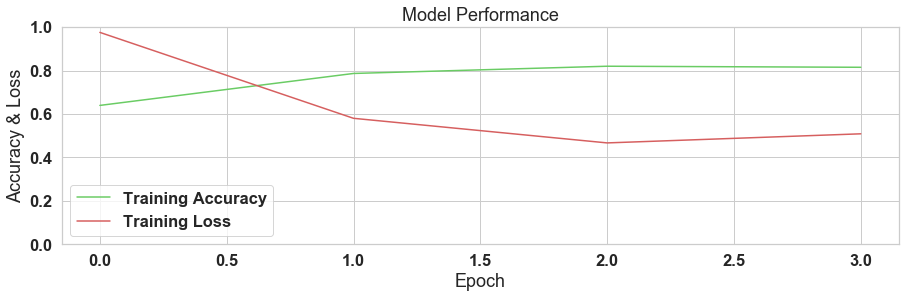

In [25]:
#Save the best model and give an important file name
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss', save_best_only=True),keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)]

#We are going to base convergence on accuracy
#A second epoch in a row with no improvement on accuracy will end the fitting
model_m.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=callbacks_list,validation_split=0.2,verbose=1)

#Make a pre-linary plot of the figure to see how it did
plt.figure(figsize=(15, 4))
plt.plot(history.history['accuracy'], "g-", label="Training Accuracy")
#plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r-", label="Training Loss")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [149]:
#This lets me save the model run metrics over epochs
#Saved as dictionary
#I manually name them and reload them if the notebook is fresh and the contents not in memory
import pickle
try:
    save_dict
except NameError:
    with open('trainHistoryDict.txt', 'rb') as file_pi:
        save_dict = pickle.load(file_pi)
    print('re-opened')
else:
    print('continuing')
    
model = "2LSTM300Layer"
save_dict.update({model:history.history})
#save_dict = {model:history.history}
with open('trainHistoryDict.txt', 'wb') as file_pi:
    pickle.dump(save_dict, file_pi)
with open('trainHistoryDict.txt', 'rb') as file_pi:
    contents = pickle.load(file_pi)
#print(contents)

continuing


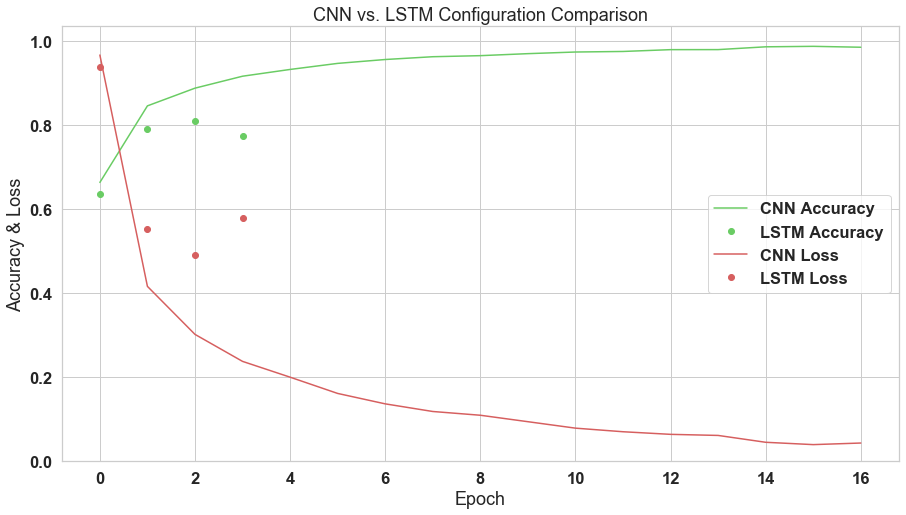

In [178]:
#Make a plot of different architectures and their metrics
#This shows removing dropout vs. no post avg pooling conv1d layers vs. default result
plt.figure(figsize=(15, 8))
plt.plot(contents['Default']['accuracy'], "g-", label="CNN Accuracy")
plt.plot(contents['2LSTM300Layer']['accuracy'], "go", label="LSTM Accuracy")
#plt.plot(contents['Minus2PostConv1D']['accuracy'], "g--", label="Minus 2 PostConv1D Accuracy",linewidth=4)
#plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(contents['Default']['loss'], "r-", label="CNN Loss")
plt.plot(contents['2LSTM300Layer']['loss'], "ro", label="LSTM Loss")
#plt.plot(contents['Minus2PostConv1D']['loss'], "r--", label="Minus 2 PostConv1D Loss",linewidth=4)
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('CNN vs. LSTM Configuration Comparison')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

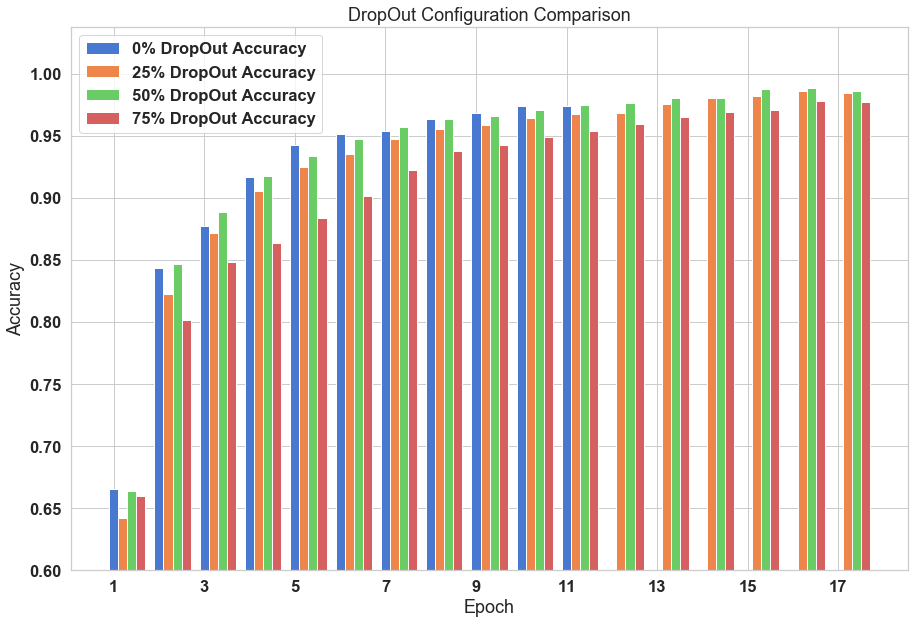

In [52]:
#This shows the dropout comparison for final metrics over epochs
#Default dropout is 50%
plt.figure(figsize=(15, 10))
width = 0.2
plt.bar(np.arange(1+0*width,1+0*width+len(contents['NoDropOut']['accuracy']), 1).tolist(),contents['NoDropOut']['accuracy'],width,label="0% DropOut Accuracy")
plt.bar(np.arange(1+1*width,1+1*width+len(contents['25DropOut']['accuracy']), 1).tolist(),contents['25DropOut']['accuracy'],width,label="25% DropOut Accuracy")
plt.bar(np.arange(1+2*width,1+2*width+len(contents['Default']['accuracy']), 1).tolist(),contents['Default']['accuracy'],width,label="50% DropOut Accuracy")
plt.bar(np.arange(1+3*width,1+3*width+len(contents['75DropOut']['accuracy']), 1).tolist(),contents['75DropOut']['accuracy'],width,label="75% DropOut Accuracy")
plt.title('DropOut Configuration Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.6)
plt.xticks([1,3,5,7,9,11,13,15,17])
plt.legend()
plt.show()

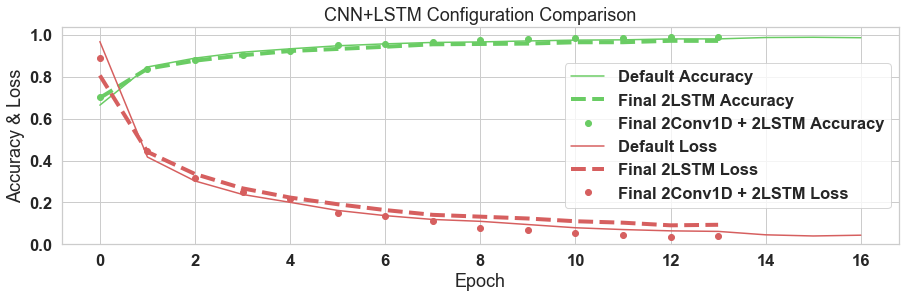

In [53]:
#This visualization is to compare how adding LSTM at the end of CNN affects metrics over epochs
#Adding LSTM in addition to Default CNN helps slightly
plt.figure(figsize=(15, 4))
plt.plot(contents['Default']['accuracy'], "g-", label="Default Accuracy")
plt.plot(contents['Final2LSTM']['accuracy'], "g--", label="Final 2LSTM Accuracy",linewidth=4)
plt.plot(contents['Final2Conv1D+2LSTM']['accuracy'], "go", label="Final 2Conv1D + 2LSTM Accuracy")
#plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(contents['Default']['loss'], "r-", label="Default Loss")
plt.plot(contents['Final2LSTM']['loss'], "r--", label="Final 2LSTM Loss",linewidth=4)
plt.plot(contents['Final2Conv1D+2LSTM']['loss'], "ro", label="Final 2Conv1D + 2LSTM Loss")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('CNN+LSTM Configuration Comparison')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

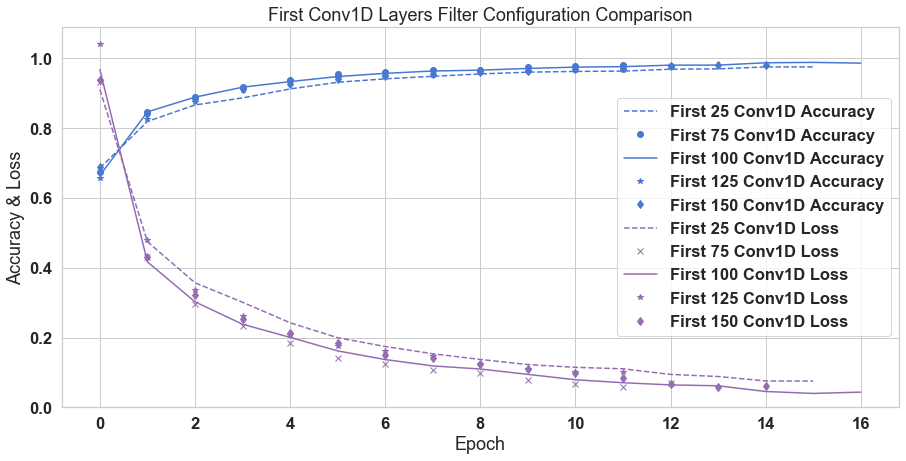

In [54]:
#This is comparing the difference in number of layers fed to each early Conv1D layer
#100 layers, the default, performs best, which is Default
plt.figure(figsize=(15, 7))
plt.plot(contents['First25Conv1D']['accuracy'], "b--", label="First 25 Conv1D Accuracy")
plt.plot(contents['First75Conv1D']['accuracy'], "bo", label="First 75 Conv1D Accuracy")
plt.plot(contents['Default']['accuracy'], "b-", label="First 100 Conv1D Accuracy")
plt.plot(contents['First125Conv1D']['accuracy'], "b*", label="First 125 Conv1D Accuracy")
plt.plot(contents['First150Conv1D']['accuracy'], "bd", label="First 150 Conv1D Accuracy")
#plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(contents['First25Conv1D']['loss'], "m--", label="First 25 Conv1D Loss")
plt.plot(contents['First75Conv1D']['loss'], "mx", label="First 75 Conv1D Loss")
plt.plot(contents['Default']['loss'], "m-", label="First 100 Conv1D Loss")
plt.plot(contents['First125Conv1D']['loss'], "m*", label="First 125 Conv1D Loss")
plt.plot(contents['First150Conv1D']['loss'], "md", label="First 150 Conv1D Loss")
#plt.plot(contents['Final2Conv1D+2LSTM']['loss'], "ro", label="Final 2Conv1D + 2LSTM Loss")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('First Conv1D Layers Filter Configuration Comparison')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [22]:
#This looks at the kernel size of the first Conv1D layers
#A size of 10 kernels (no padding) performs best, which is Default
plt.figure(figsize=(15, 6))
plt.plot(contents['First5KernelConv1D']['accuracy'], "rx", label="First 5 Kernel Conv1D Accuracy",linewidth=2)
plt.plot(contents['First8KernelConv1D']['accuracy'], "ro", label="First 8 Kernel Conv1D Accuracy",linewidth=3)
#plt.plot(contents['First75Conv1D']['accuracy'], "bo", label="First 75 Conv1D Accuracy")
plt.plot(contents['Default']['accuracy'], "r-", label="First 10 Kernel Conv1D Accuracy")
plt.plot(contents['First12KernelConv1D']['accuracy'], "rd", label="First 12 Kernel Conv1D Accuracy",linewidth=4)
#plt.plot(contents['First125Conv1D']['accuracy'], "b*", label="First 125 Conv1D Accuracy")
#plt.plot(contents['First150Conv1D']['accuracy'], "bd", label="First 150 Conv1D Accuracy")
#plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(contents['First5KernelConv1D']['loss'], "mx", label="First 5 Kernel Conv1D Loss",linewidth=2)
plt.plot(contents['First8KernelConv1D']['loss'], "mo", label="First 8 Kernel Conv1D Loss",linewidth=3)
#plt.plot(contents['First75Conv1D']['loss'], "mx", label="First 75 Conv1D Loss")
plt.plot(contents['Default']['loss'], "m-", label="First 10 Kernel Conv1D Loss")
plt.plot(contents['First12KernelConv1D']['loss'], "md", label="First 12 Kernel Conv1D Loss",linewidth=4)
#plt.plot(contents['First125Conv1D']['loss'], "m*", label="First 125 Conv1D Loss")
#plt.plot(contents['First150Conv1D']['loss'], "md", label="First 150 Conv1D Loss")
#plt.plot(contents['Final2Conv1D+2LSTM']['loss'], "ro", label="Final 2Conv1D + 2LSTM Loss")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('First Conv1D Layers Kernel Configuration Comparison')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylim(0)
plt.legend()
plt.show()

NameError: name 'contents' is not defined

<Figure size 1080x432 with 0 Axes>

In [88]:
print('The best default accuracy is: ',max(contents['Default']['accuracy']))
print('The best default loss is: ',max(contents['Default']['loss']))
print('The best default + 2LTSM accuracy is: ',max(contents['Final2Conv1D+2LSTM']['accuracy']))
print('The best default + 2LTSM loss is: ',max(contents['Final2Conv1D+2LSTM']['loss']))
print('The best default + 1LTSM accuracy is: ',max(contents['CNNAndOneLSTM']['accuracy']))
print('The best default + 1LTSM loss is: ',max(contents['CNNAndOneLSTM']['loss']))

NameError: name 'contents' is not defined

Text(0.11, 0.5, 'Filters')

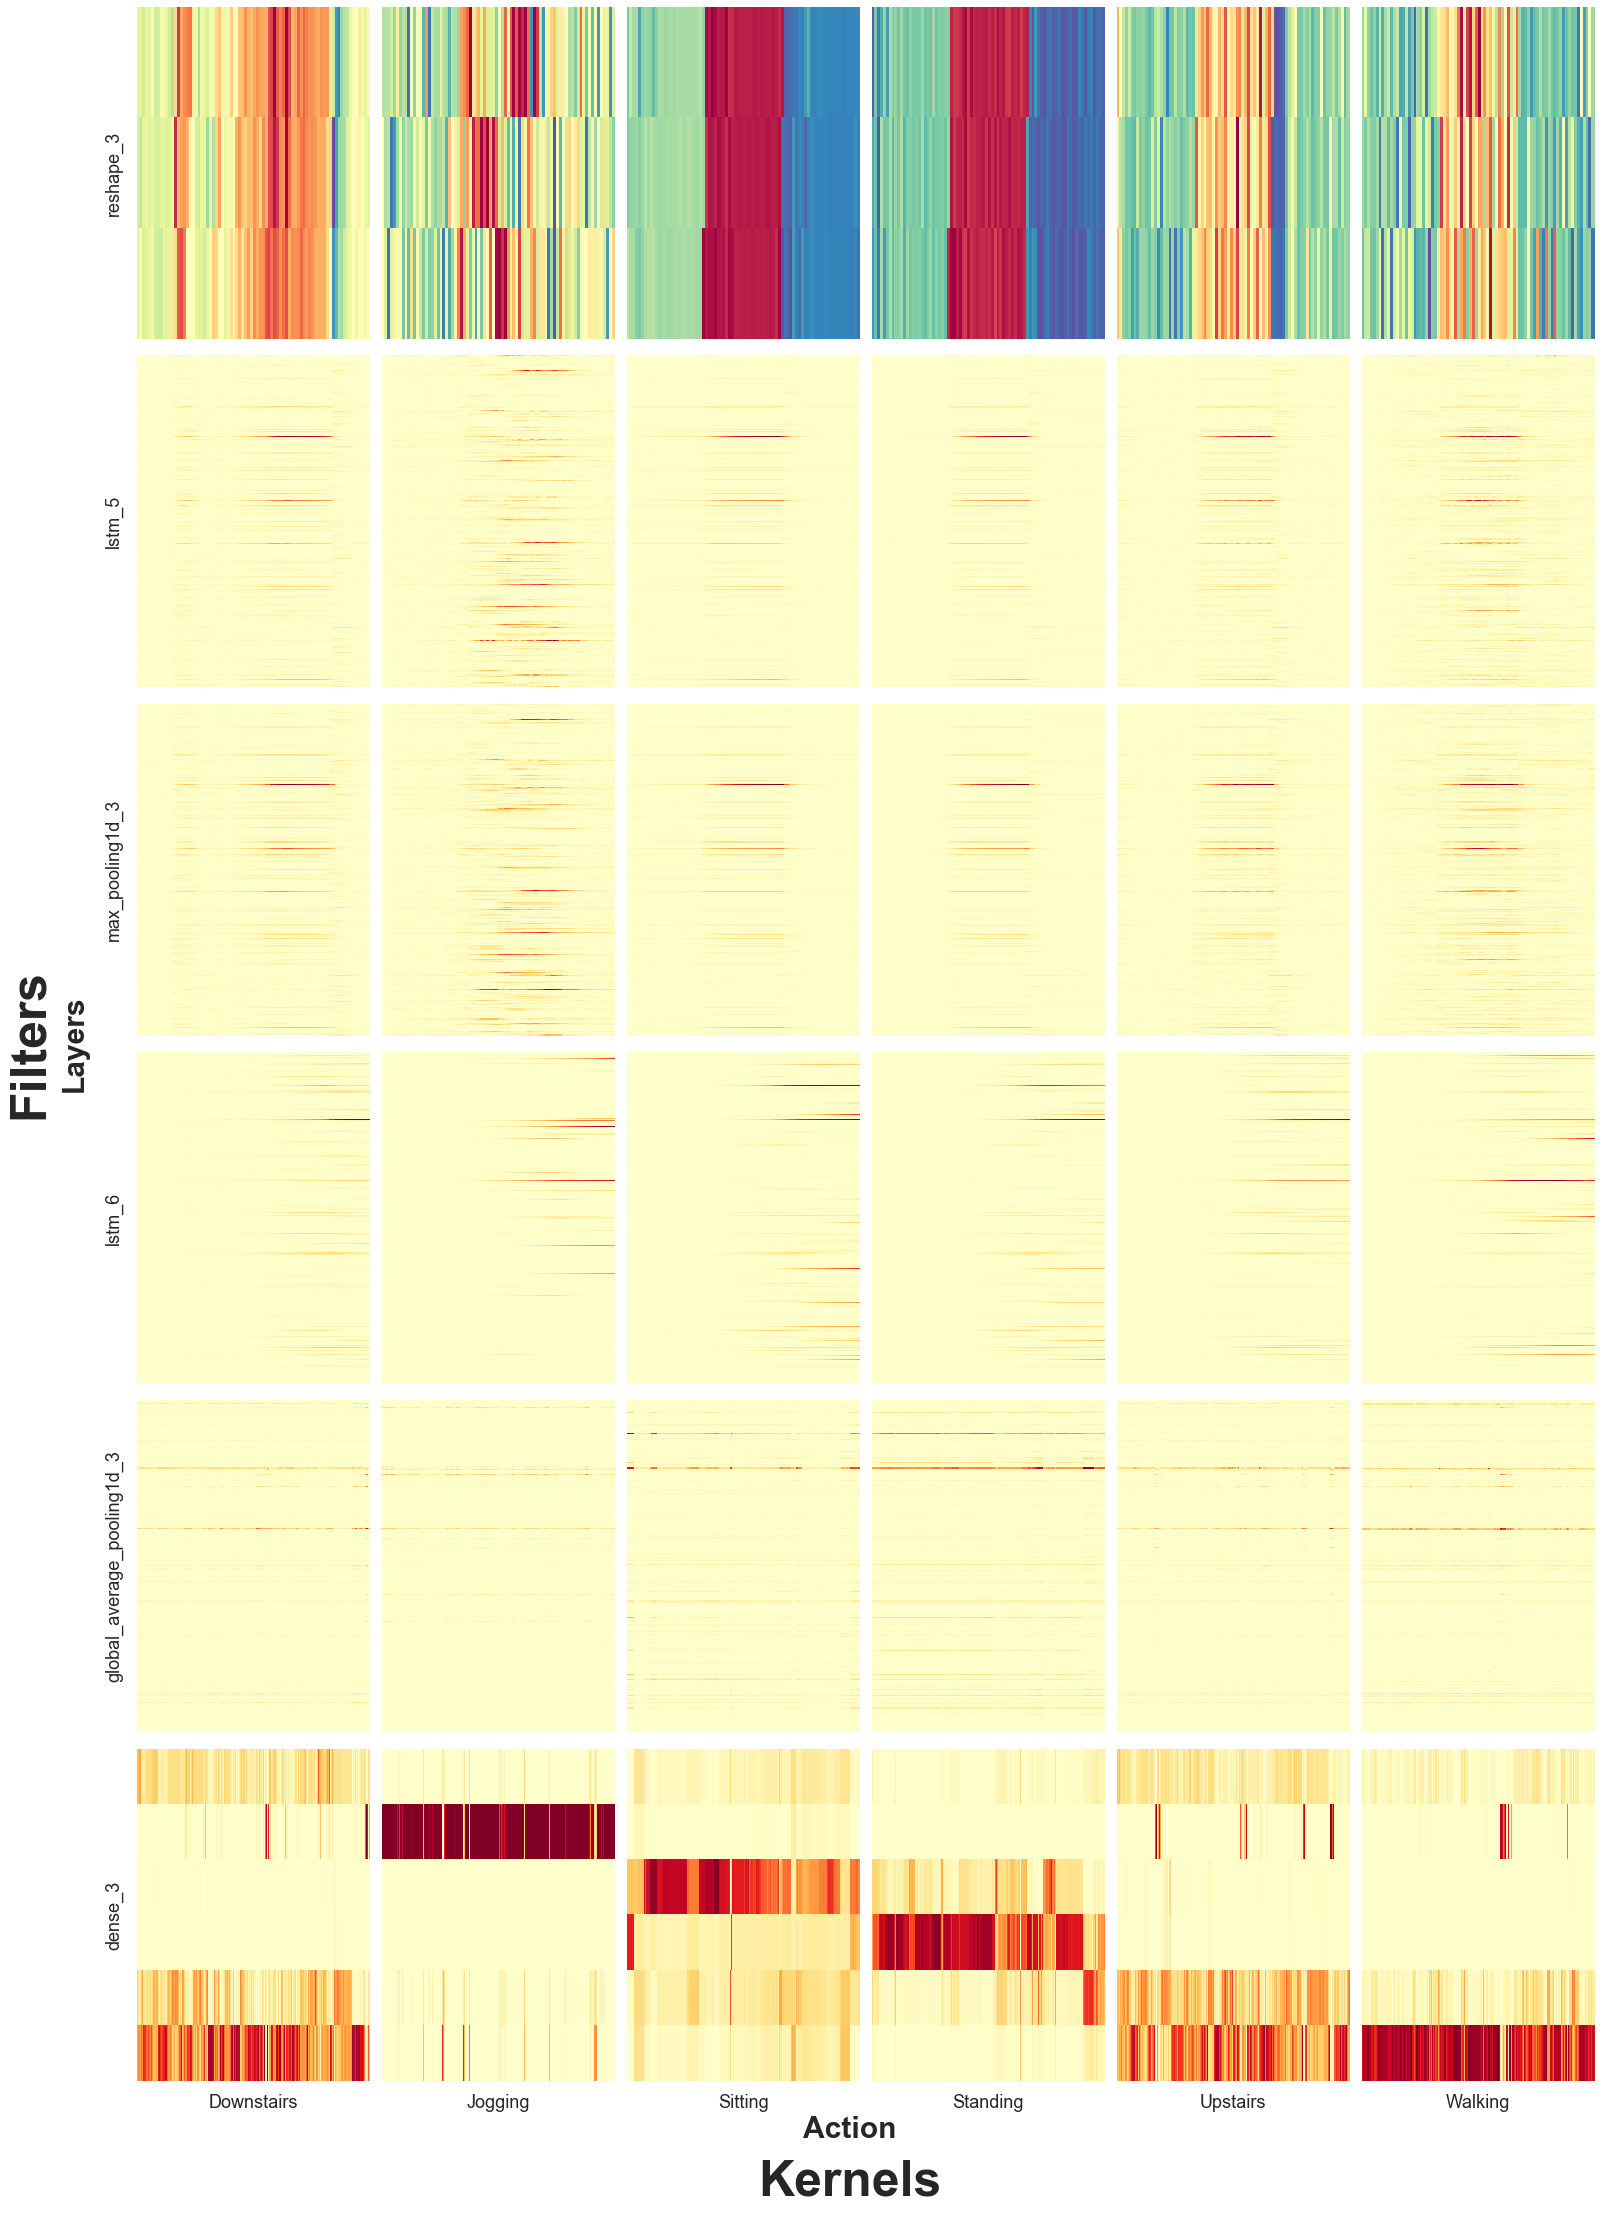

In [34]:
#This makes a heatmap of all the layers for all the actions.
#This shows either output or activation per layer, depending if that layer was created using relu or, if none, linear by keras default
from keras import backend as K
import matplotlib.gridspec as gridspec
#Get number of total layers added to model
lay_len = len(model_m.layers)
#lay_len = 2
#Get name of activities
activities = list(mapping.keys())
#Get number of activities
act_len = len(activities)

#Set figure size
fig = plt.figure(figsize=(30,32)) 

#To show all this, it's easiest to manage with gridspec, iterating over ever cell in each row (layer) and column (action)
gs = gridspec.GridSpec(lay_len, act_len, width_ratios=[1,1,1,1,1,1],
                       wspace=0.05, hspace=0.05, top=0.95, bottom=0.05, left=0.17, right=0.845) 

#Iterate through layers
for layer in range(0,lay_len):
    #Since first layer is the re-centered acceleration (raw), I'd like to show blue as negative acc/red as positive acc
    if layer == 0:
        cmap = 'Spectral_r'
    #For the remaining layers, since they are output/activation, I'd like to show a gradient of none to positive
    else:
        cmap = 'YlOrRd'
    #Iterate through the activities
    for i in range(0,len(activities)):
        #Create a segment of x
        seg_x = create_segments_and_labels(df[df['ActivityEncoded']==i],TIME_PERIODS,STEP_DISTANCE,LABEL)[0]
        #Get the output of the layer from keras, if no activation specified it is just output
        get_layer_output = K.function([model_m.layers[0].input],[model_m.layers[layer].output])
        #Use the aforementioned function to get results
        layer_output = get_layer_output([seg_x])[0]
        #Add the subplot aka the cell to the grid
        ax = fig.add_subplot(gs[layer,i])
        try:
            #Generate the heatmap
            sns.heatmap(layer_output[0].transpose(),cbar=False,cmap=cmap)
        except:
            #Later layers have different dimensions as model.summary shows
            sns.heatmap(layer_output.transpose(),cbar=False,cmap=cmap)
        #Remove these labels for simplicity
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if layer == (lay_len-1):
            #Set the activity for the last layer
            ax.set_xlabel(activities[i])
        if i == 0:
            #Set the layer name for the first column
            ax.set_ylabel(model_m.layers[layer].name)
#Name axes
#Each subplots y axis is in filters. The y axis of the subplots collectively is Filters
#Each subplots x axis is in kerels. The x axis of the subplots collectively is Action
fig.text(0.5, 0.025, 'Action', ha='center',fontsize=30)
fig.text(0.135, 0.5, 'Layers', va='center', rotation='vertical',fontsize=30)
fig.text(0.5, 0.00, 'Kernels', ha='center',fontsize=50)
fig.text(0.11, 0.5, 'Filters', va='center', rotation='vertical',fontsize=50)

Text(0.5, 1, 'Model Input\n(Layer=Reshape)(Activity=Downstairs)')

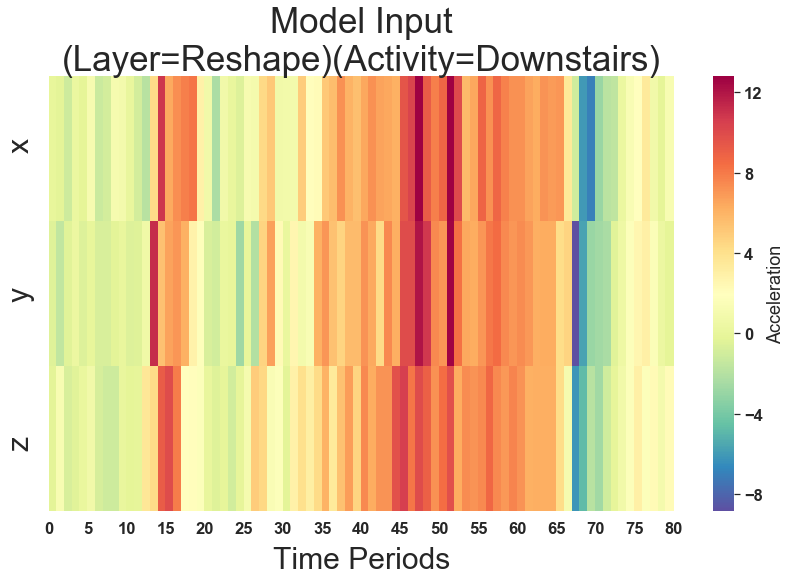

In [156]:
#Do the same thing as above but just for one subplot
#Here we look at just the input for Downstairs (see CNN discussion on Canvas)
activity = 'Downstairs'
layer = 0

seg_x = create_segments_and_labels(df[df['ActivityEncoded']==mapping[activity]],TIME_PERIODS,STEP_DISTANCE,LABEL)[0]
get_layer_output = K.function([model_m.layers[0].input],[model_m.layers[layer].output])
layer_output = get_layer_output([seg_x])[0]
inp = layer_output[0].transpose()

ax = sns.heatmap(inp,cbar=True,cmap= 'Spectral_r',cbar_kws={'label':'Acceleration'})

ax.set_xlabel('Time Periods',fontsize=30)
#ax.set_yticks(range(0,len(layer_output[0][0])+1,10))
ax.set_yticklabels('')
ax.set_xticks(range(0,len(layer_output[0])+1,5))
ax.set_xticklabels(range(0,len(layer_output[0])+1,5))
ax.set_ylabel('z                y                x',fontsize=30)
ax.xaxis.labelpad = 10
ax.set_title('Model Input\n(Layer=Reshape)(Activity=' + activity + ')',fontsize=35)

Text(0.5, 1, 'Filter vs. Kernel\n(Layer=1st Conv1D)(Activity=Upstairs)')

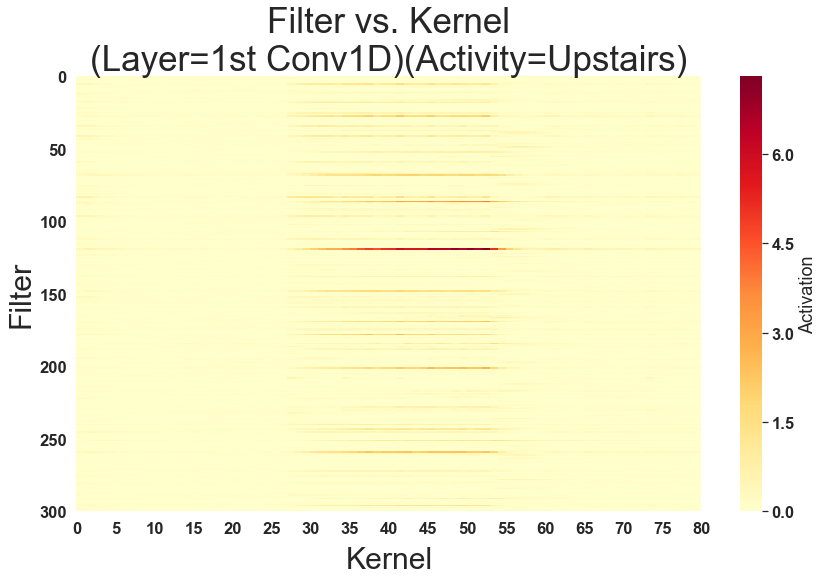

In [175]:
#Same as above but for the first layer after input, the first CNN layer Conv1D
#A lot of the noise remains

from keras import backend as K
cmap = 'YlOrRd'
activity = 'Upstairs'
layer = 1


seg_x = create_segments_and_labels(df[df['ActivityEncoded']==mapping[activity]],TIME_PERIODS,STEP_DISTANCE,LABEL)[0]
get_layer_output = K.function([model_m.layers[0].input],[model_m.layers[layer].output])
layer_output = get_layer_output([seg_x])[0]

try: 
    ax = sns.heatmap(layer_output[0].transpose(),cbar=True,cbar_kws={'label':'Activation'},cmap=cmap)
except:
    ax = sns.heatmap(layer_output.transpose(),cbar=True,cbar_kws={'label':'Activation'},cmap=cmap)

ax.set_xlabel('Kernel',fontsize=30)
ax.set_yticks(range(0,len(layer_output[0][0])+1,50))
ax.set_yticklabels(range(0,len(layer_output[0][0])+1,50))
ax.set_xticks(range(0,len(layer_output[0])+1,5))
ax.set_xticklabels(range(0,len(layer_output[0])+1,5))
ax.set_ylabel('Filter',fontsize=30)
ax.xaxis.labelpad = 10
ax.set_title('Filter vs. Kernel\n(Layer=1st Conv1D)(Activity=' + activity + ')',fontsize=35)

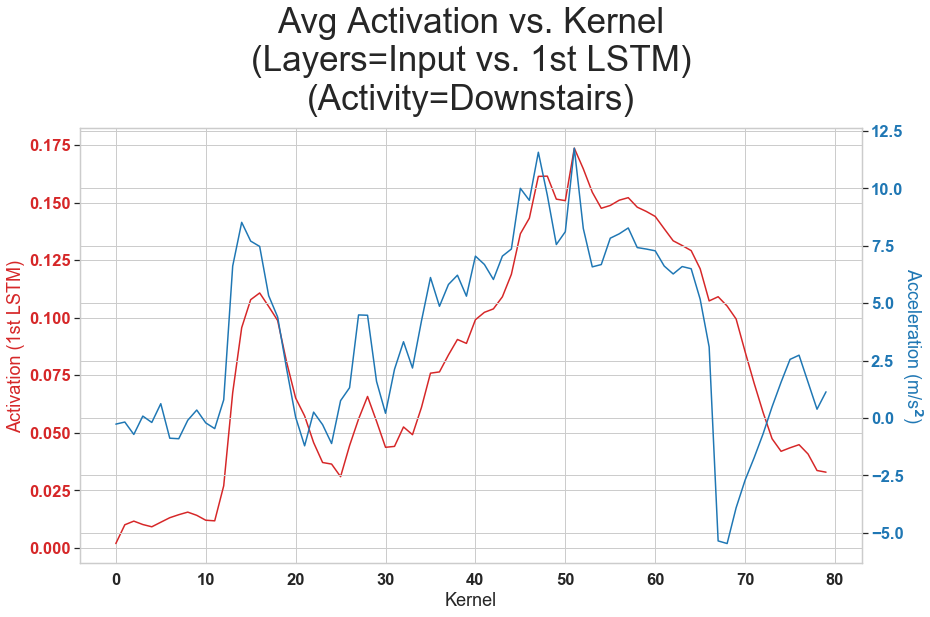

In [164]:
#If I average the above image across Filters, what is the average activation per kernel?
#This should represent a smoothed image of the features it's looking for
#Like the heatmap, there is the user accelerating to start the stairs, then decelerating to stop when they finish
#Both uptick activations, temporally speaking, for this start/stop for important moments
#Since this is an early Conv1D Layer, there is still a lot of noise across the filters
#seg_x = create_segments_and_labels(df[df['ActivityEncoded']==mapping['Downstairs']],TIME_PERIODS,STEP_DISTANCE,LABEL)[0]
#get_layer_output = K.function([model_m.layers[0].input],[model_m.layers[0].output])
#inp = get_layer_output([seg_x])[0].transpose()[0]

#sns.set_style("darkgrid", {"axes.facecolor": ".9"})

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Kernel')
ax1.set_ylabel('Activation (1st LSTM)', color=color)

avgs = []
avgs2 = []

for i in range(0,layer_output[0].shape[0]):
    avgs.insert(i,np.mean(layer_output[0][i]))
for j in range(0,inp.transpose().shape[0]):
    avgs2.insert(j,np.mean(inp.transpose()[j]))
    
offset = int((len(avgs2) - len(avgs) - 1)/2)
    
ax1.plot(range(offset,len(avgs)+offset),avgs, color=color)
ax1.tick_params(axis='y', labelcolor=color)    

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Acceleration (m/s$^2$)', color=color,rotation=270,labelpad=20)  # we already handled the x-label with ax1
ax2.plot(range(0,len(avgs2)),avgs2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
    
#ax = sns.lineplot(range(4,len(avgs)+4),avgs)
#ax2 = sns.lineplot(range(0,len(avgs2)),avgs2)
#ax.set_xlabel('Kernel',fontsize=30)
#ax.set_ylabel('Acceleration',fontsize=30)
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
#ax2.set_ylabel('Activation',fontsize=30)
#ax.xaxis.labelpad = 10
title = ax1.set_title('Avg Activation vs. Kernel\n(Layers=Input vs. 1st LSTM)\n(Activity=' + activity + ')',fontsize=35)
title.set_position([.5, 1.03])

#ax2.arrow(0, 5, offset*1.5, 0, head_width=1, head_length=1, fc='k', ec='k')
#ax2.arrow(80, 5, -offset*1.5, 0, head_width=1, head_length=1, fc='k', ec='k')

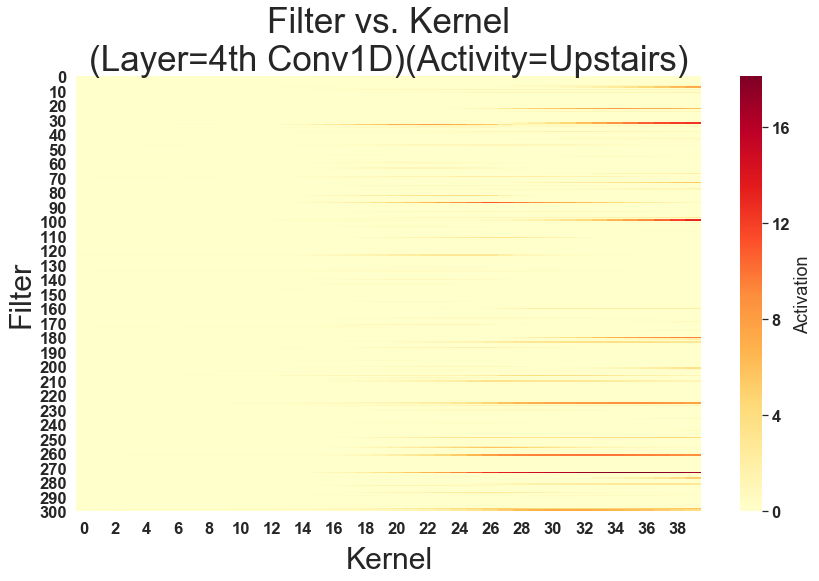

In [176]:
#Like above but looking at 6th layer, the 4th Conv1D layer

activity = 'Upstairs'
layer = 3

seg_x = create_segments_and_labels(df[df['ActivityEncoded']==mapping[activity]],TIME_PERIODS,STEP_DISTANCE,LABEL)[0]
get_layer_output = K.function([model_m.layers[0].input],[model_m.layers[layer].output])
layer_output2 = get_layer_output([seg_x])[0]

try: 
    ax = sns.heatmap(layer_output2[0].transpose(),cbar=True,cbar_kws={'label':'Activation'},cmap=cmap)
except:
    ax = sns.heatmap(layer_output2[0].transpose(),cbar=True,cbar_kws={'label':'Activation'},cmap=cmap)

ax.set_xlabel('Kernel',fontsize=30)
ax.set_yticks(range(0,len(layer_output2[0].transpose())+1,10))
ax.set_yticklabels(range(0,len(layer_output2[0].transpose())+1,10))
#ax.set_xticks(range(0,len(layer_output2)+))
#ax.set_xticklabels(range(0,len(layer_output2)))
ax.set_ylabel('Filter',fontsize=30)
ax.xaxis.labelpad = 10
title = ax.set_title('Filter vs. Kernel\n(Layer=4th Conv1D)(Activity=' + activity + ')',fontsize=35)
title.set_position([.5, 1.05])

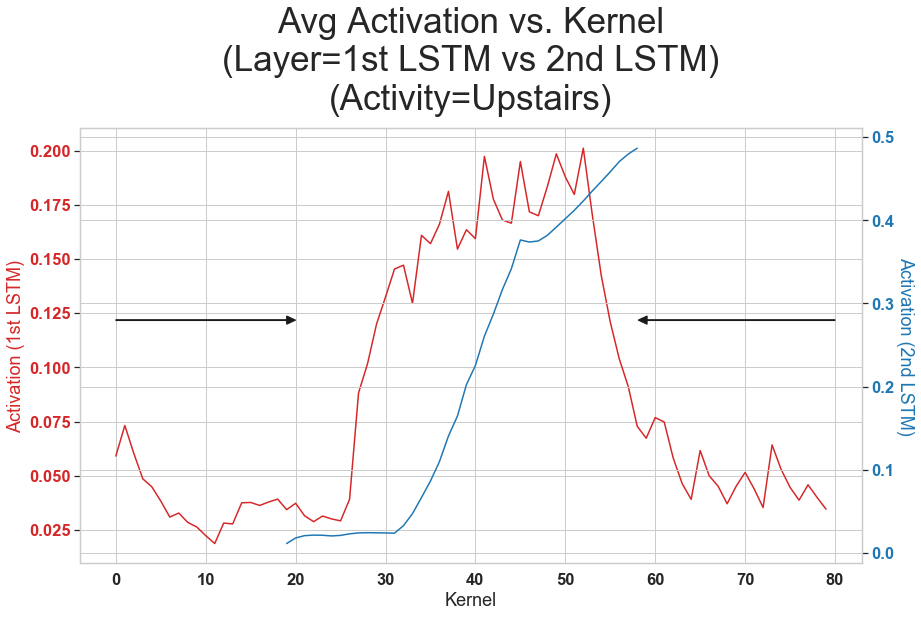

In [177]:
#If I average the above image across Filters, what is the average activation per kernel?
#This should represent a smoothed image of the features it's looking for
#Like the heatmap, there is the user accelerating to start the stairs, then decelerating to stop when they finish
#Both uptick activations, temporally speaking, for this start/stop for important moments
#Since this is an early Conv1D Layer, there is still a lot of noise across the filters

#Here we show the input of downstairs overlayed with what the first Conv1D layer does with activations of these features
#The compressed range is over less kernels, due to kernel window with no padding

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Kernel')
ax1.set_ylabel('Activation (1st LSTM)', color=color)

avgs = []
avgs2 = []

#Take the mean across all the layers for the avg activation per kernel of the 2nd layer
for i in range(0,layer_output[0].shape[0]):
    avgs.insert(i,np.mean(layer_output[0][i]))

#Take the mean across all the filters for the avg activation per kernel of the 6th layer
for j in range(0,layer_output2[0].shape[0]):
    avgs2.insert(j,np.mean(layer_output2[0][j]))

#Offset centers the overlay's x position, due to the reduction in kernels
offset = int((len(avgs) - len(avgs2) - 1)/2)
    
ax1.plot(range(0,len(avgs)),avgs, color=color)
ax1.tick_params(axis='y', labelcolor=color)    

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Activation (2nd LSTM)', color=color,va='top',rotation=270,labelpad=20)  # we already handled the x-label with ax1
ax2.plot(range(offset,len(avgs2)+offset),avgs2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.arrow(0, 0.28, offset, 0, head_width=0.01, head_length=1, fc='k', ec='k')
ax2.arrow(80, 0.28, -offset*1.1, 0, head_width=0.01, head_length=1, fc='k', ec='k')

title = ax1.set_title('Avg Activation vs. Kernel\n(Layer=1st LSTM vs 2nd LSTM)\n(Activity=' + activity + ')',fontsize=35)
title.set_position([.5, 1.03])

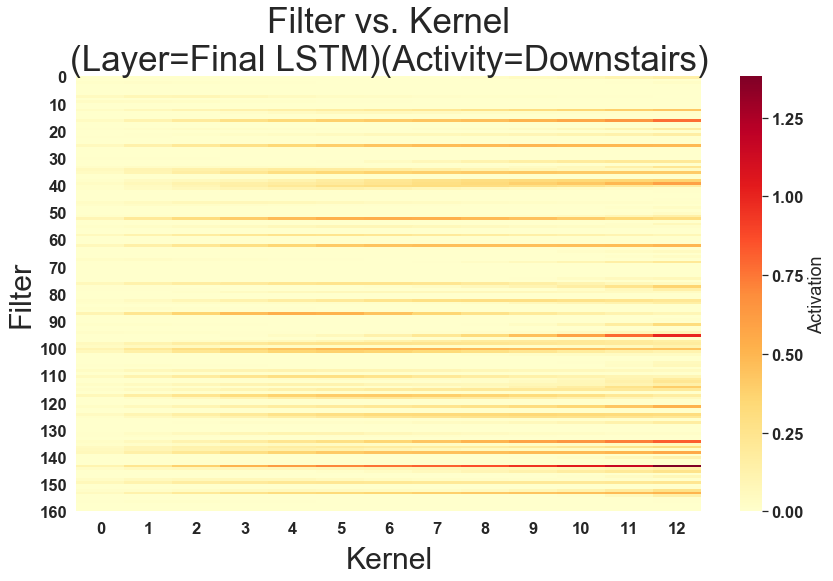

In [262]:
#Like above but looking at 6th layer, the 4th Conv1D layer

activity = 'Downstairs'
layer = 6

seg_x = create_segments_and_labels(df[df['ActivityEncoded']==mapping[activity]],TIME_PERIODS,STEP_DISTANCE,LABEL)[0]
get_layer_output = K.function([model_m.layers[0].input],[model_m.layers[layer].output])
layer_output3 = get_layer_output([seg_x])[0]

try: 
    ax = sns.heatmap(layer_output3[0].transpose(),cbar=True,cbar_kws={'label':'Activation'},cmap=cmap)
except:
    ax = sns.heatmap(layer_output3[0].transpose(),cbar=True,cbar_kws={'label':'Activation'},cmap=cmap)

ax.set_xlabel('Kernel',fontsize=30)
ax.set_yticks(range(0,len(layer_output3[0].transpose())+1,10))
ax.set_yticklabels(range(0,len(layer_output3[0].transpose())+1,10))
#ax.set_xticks(range(0,len(layer_output3.transpose())+1),100)
#ax.set_xticklabels(range(0,len(layer_output3.t)+1),100)
ax.set_ylabel('Filter',fontsize=30)
ax.xaxis.labelpad = 10
title = ax.set_title('Filter vs. Kernel\n(Layer=Final LSTM)(Activity=' + activity + ')',fontsize=35)
title.set_position([.5, 1.05])

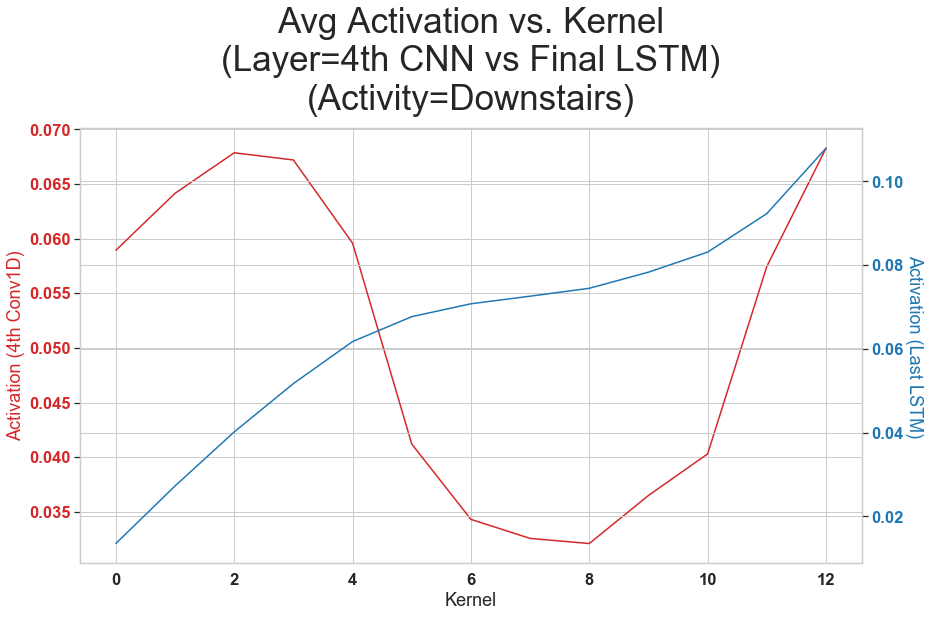

In [263]:
#4thCNN vs Final LSTM pre avg pooling
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Kernel')
ax1.set_ylabel('Activation (4th Conv1D)', color=color)

avgs = []
avgs2 = []

#Take the mean across all the layers for the avg activation per kernel of the 2nd layer
for i in range(0,layer_output2[0].shape[0]):
    avgs.insert(i,np.mean(layer_output2[0][i]))

#Take the mean across all the filters for the avg activation per kernel of the 6th layer
for j in range(0,layer_output3[0].shape[0]):
    avgs2.insert(j,np.mean(layer_output3[0][j]))

#Offset centers the overlay's x position, due to the reduction in kernels
offset = -int((len(avgs) - len(avgs2) - 1)/2)
    
ax1.plot(range(offset,len(avgs)+offset),avgs, color=color)
ax1.tick_params(axis='y', labelcolor=color)    

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Activation (Last LSTM)', color=color,va='top',rotation=270,labelpad=20)  # we already handled the x-label with ax1
ax2.plot(range(0,len(avgs2)),avgs2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#ax2.arrow(0, 0.2, offset*0.95, 0, head_width=0.01, head_length=1, fc='k', ec='k')
#ax2.arrow(70, 0.2, -offset, 0, head_width=0.01, head_length=1, fc='k', ec='k')

title = ax1.set_title('Avg Activation vs. Kernel\n(Layer=4th CNN vs Final LSTM)\n(Activity=' + activity + ')',fontsize=35)
title.set_position([.5, 1.03])

In [31]:
list(labels)

['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

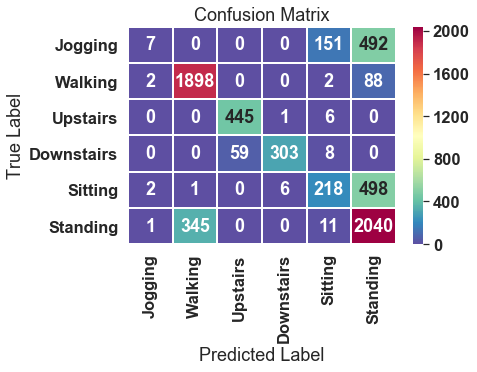

              precision    recall  f1-score   support

           0       0.58      0.01      0.02       650
           1       0.85      0.95      0.90      1990
           2       0.88      0.98      0.93       452
           3       0.98      0.82      0.89       370
           4       0.55      0.30      0.39       725
           5       0.65      0.85      0.74      2397

    accuracy                           0.75      6584
   macro avg       0.75      0.65      0.64      6584
weighted avg       0.73      0.75      0.70      6584



In [33]:
from keras.models import load_model
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import os

LABELS=list(labels)

#Make training data in segmented form from this subset of users
x_test, y_test = create_segments_and_labels(df_test,TIME_PERIODS,STEP_DISTANCE,LABEL)
x_test = x_test.reshape(x_test.shape[0], input_shape)
y_test = np_utils.to_categorical(y_test, len(mapping))
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='Spectral_r',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))